# Boston Crime Data - Top 5 in 2020 - Quarter-wise

In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn import metrics

crime_data = pd.read_csv('E:\Coursera\TabPy\TPublic\script_113631134_20210423193017_combine.csv',
                         dtype={"INCIDENT_NUMBER": object, "OFFENSE_CODE": np.int64,"OFFENSE_CODE_GROUP" : np.float64,
                               "OFFENSE_DESCRIPTION" : object,"DISTRICT" :object,"REPORTING_AREA" :object,
                               "SHOOTING" :np.int64,"OCCURRED_ON_DATE" :object,"YEAR" : np.int64,"MONTH" :np.int64,
                               "DAY_OF_WEEK" : object,"HOUR" :np.int64,"UCR_PART":np.float64,"STREET":object,
                               "Lat" : np.float64, "Long" :np.float64,"Location" :object})

# Filtering the rows with zero Lat and Long
crime_data = crime_data[(crime_data['Lat'] != 0) & (crime_data['Long'] != 0)]

In [2]:
#filtering only Vandalism events
part_data = crime_data[crime_data['OFFENSE_DESCRIPTION'].isin(['INVESTIGATE PERSON','SICK ASSIST','M/V - LEAVING SCENE - PROPERTY DAMAGE','INVESTIGATE PROPERTY',
                                                               'ASSAULT - SIMPLE'])]
part_data = part_data[((part_data['MONTH'] > 9))]
part_data = part_data.reset_index(drop = True)
part_data.set_index(np.arange(len(part_data)))
print(part_data.shape)

(4506, 17)


# DBSCAN - Fit the model

In [3]:
#For Haversine metric, all values hav to be in radians. 
kms_per_radian = 6371.0088
epsilon = 0.4/kms_per_radian
min_samples = 3

# Converting Lat and Long columns to radians and stacking to form an array
coords = np.column_stack([np.radians(part_data['Lat']),np.radians(part_data['Long'])])
db = DBSCAN(eps=epsilon, min_samples=min_samples,algorithm = 'ball_tree',metric = 'haversine').fit(coords)
cluster_labels = db.labels_

no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 11
Estimated no. of noise points: 20


In [4]:
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
print(clusters)

0     [[0.7384438945980679, -1.2410040481540403], [0...
1     [[0.7391304623167847, -1.2418104632559268], [0...
2     [[0.7395102816783893, -1.2398695224162388], [0...
3     [[0.7376913349907595, -1.241864588102777], [0....
4     [[0.7395911117536316, -1.240354996350516], [0....
5     [[0.7380069363453788, -1.2417383570294505], [0...
6     [[0.7378896671355714, -1.2421842156874128], [0...
7     [[0.7397473278516892, -1.2395035458530625], [0...
8     [[0.7375024284309571, -1.2417227872358414], [0...
9     [[0.7381279847288414, -1.2398966504442142], [0...
10                                                   []
dtype: object


In [5]:
#merging Coordinates with Cluster details 

X_df = pd.DataFrame(coords)
db_cluster = pd.DataFrame(cluster_labels)  

df = pd.concat([X_df, db_cluster], axis=1)

df.columns = ['Lat', 'Long', 'dbscan_cluster']
df['Lat'] = np.degrees(df['Lat'])
df['Long'] = np.degrees(df['Long'])
df.shape

(4506, 3)

# Plot the clusters

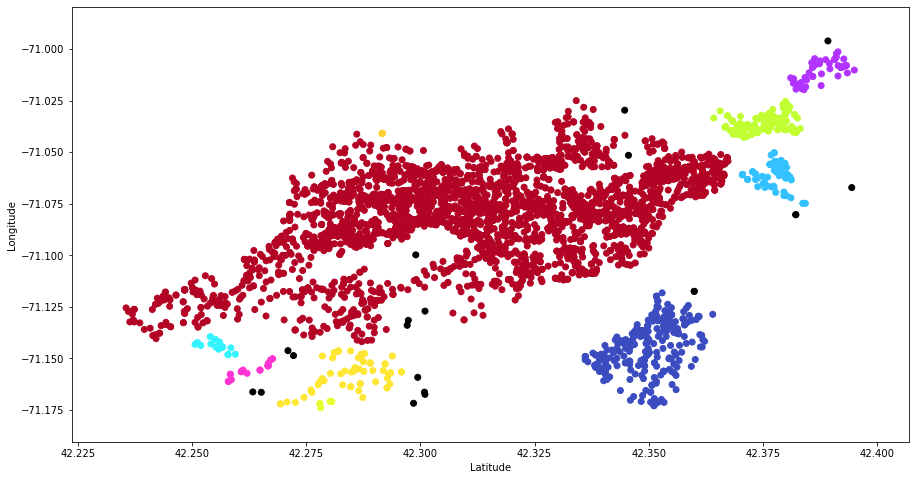

In [6]:
colors = {
   0: '#b40426',
  1: '#3b4cc0',
    2: '#C1FF33',
    3:'#FF33D4',
    4:'#33C1FF',
    5:'#FFE633',
    6:'#E6FF33',
    7:'#B233FF',
    8:'#33F3FF',
    9:'#FFCE33',
    10:'#FFAF33',
    11:'#FF9033',
    12:'#eb4034',
    13:'#ede507',
    14:'#ed7e07',
    15:'#ceed07',
    16:'#07ed31',
    17:'#07e5ed',
  -1: '#000000'
}

colors = list(map(lambda x: colors[x], df['dbscan_cluster']))
fig, ax = plt.subplots(figsize=[15, 8])
df_scatter = ax.scatter(df['Lat'], df['Long'], c=colors)
# plt.xticks(np.arange(min(df['Lat']), max(df['Lat']), 0.0125))
# plt.yticks(np.arange(min(df['Long']), max(df['Long']), 0.0125))

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.show()

In [7]:
#output the data to csv file
out = pd.concat([part_data,df], axis = 1,join = 'inner')
out.to_csv('bostonQ4Top5.csv', sep=',')

In [8]:
print("Silhoette Coefficient: %0.3f" % metrics.silhouette_score(coords, cluster_labels))

Silhoette Coefficient: 0.004
